In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from gen_data import gen_data_complex
from proximal import proximal_direct_effect, ProximalDE

In [3]:
def exp_res(it, n, pw, pz, px, a, b, c, d, e, f, g, *,
            n_splits=5, semi=False, multitask=False, n_jobs=-1):
    np.random.seed(it)
    # M is unobserved so we omit it from the return variables
    W, D, _, Z, X, Y = gen_data_complex(n, pw, pz, px, a, b, c, d, e, f, g)
    return proximal_direct_effect(W, D, Z, X, Y,
                                  cv=n_splits, semi=semi,
                                  multitask=multitask, n_jobs=n_jobs,
                                  random_state=it)

In [4]:
a = .3
b = .6
c = .5 # this is the direct effect we want to estimate
d = .7
e = .5 # if the product of e*f is small, then we have a weak instrument
f = .5 # if the product of e*f is small, then we have a weak instrument
g = .9

In [5]:
import pandas as pd

n = 10000
pw = 10
pz, px = 5, 5
n_splits = 3
point, stderr, r2D, r2Z, r2X, r2Y, jac, point_pre, stderr_pre = exp_res(3, n, pw, pz, px, a, b, c, d, e, f, g,
                                                 n_splits=n_splits, semi=True)
pd.DataFrame({'point': point, 'se': stderr, 'r2D': r2D, 'r2Z': r2Z, 'r2X': r2X, 'r2Y': r2Y, 'Jacobian': jac,
              'point_pre': point_pre, 'se_pre': stderr_pre}, index=[0])

Residualizing D...
Residualizing Z...
Residualizing X...
Residualizing Y...


,point,se,r2D,r2Z,r2X,r2Y,Jacobian,point_pre,se_pre
0,0.526032,0.036299,0.365023,0.590544,0.539387,0.614712,0.155583,0.507735,0.035534


In [6]:
np.random.seed(3)
W, D, _, Z, X, Y = gen_data_complex(n, pw, pz, px, a, b, c, d, e, f, g)
est = ProximalDE(cv=3, semi=True, multitask=False, n_jobs=-1, random_state=3)
est.fit(W, D, Z, X, Y)

Residualizing D...
Residualizing Z...
Residualizing X...
Residualizing Y...


In [7]:
est.point_, est.std_

(0.5260322276129851, 0.03629901339493049)

In [22]:
point_dist = est.subsample_third_stage(n_subsamples=1000, fraction=0.5, replace=False, verbose=3)
print(np.std(point_dist))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


0.038104723235631396


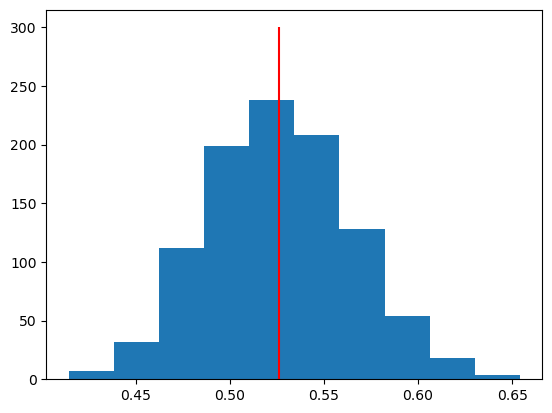

In [23]:
import matplotlib.pyplot as plt
plt.hist(point_dist)
plt.vlines([est.point_], 0, 300, color='r')
plt.show()

In [24]:
point_dist = est.subsample_second_stage(n_subsamples=1000, fraction=0.5, replace=False, verbose=3)
print(np.std(point_dist))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:   54.0s


0.05337168685164048


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.2min finished


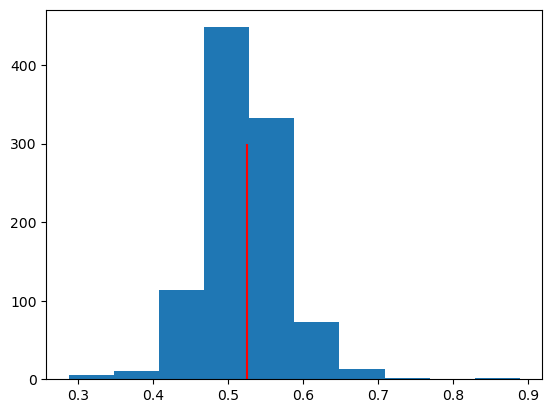

In [25]:
import matplotlib.pyplot as plt
plt.hist(point_dist)
plt.vlines([est.point_], 0, 300, color='r')
plt.show()

In [26]:
point_dist = est.subsample_all_stages(n_subsamples=100, fraction=0.5, replace=False, verbose=3)
print(np.std(point_dist))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   27.9s remaining:    1.4s


0.04472238050380597


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.4s finished


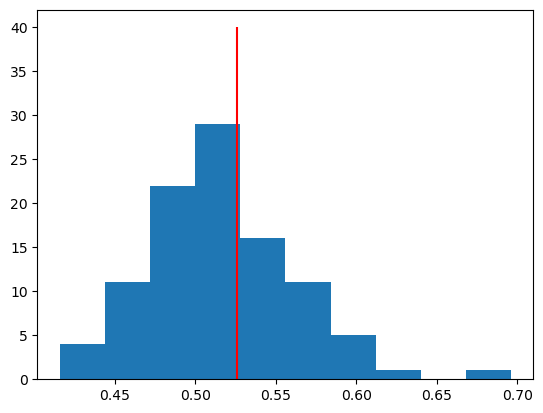

In [27]:
import matplotlib.pyplot as plt
plt.hist(point_dist)
plt.vlines([est.point_], 0, 40, color='r')
plt.show()

# Coverage Experiment

In [14]:
from joblib import Parallel, delayed

n = 10000
pw = 10
pz, px = 30, 30
n_splits = 3

results = Parallel(n_jobs=-1, verbose=3)(delayed(exp_res)(i, n, pw, pz, px, a, b, c, d, e, f, g,
                                                           n_splits=n_splits, semi=True, n_jobs=1)
                                          for i in range(100))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed: 24.3min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 24.4min finished


In [15]:
points_base, stderrs_base, rmseD, rmseZ, rmseX, rmseY, jac, points_alt, stderrs_alt = zip(*results)
points_base = np.array(points_base)
stderrs_base = np.array(stderrs_base)
points_alt = np.array(points_alt)
stderrs_alt = np.array(stderrs_alt)

for points, stderrs in [(points_base, stderrs_base), (points_alt, stderrs_alt)]:
    coverage = np.mean((points + 1.96 * stderrs >= c) & (points - 1.96 * stderrs <= c))
    rmse = np.sqrt(np.mean((points - c)**2))
    bias = np.abs(np.mean(points) - c)
    std = np.std(points)
    mean_stderr = np.mean(stderrs)
    mean_length = np.mean(2 * 1.96 * stderrs)
    median_length = np.median(2 * 1.96 * stderrs)
    print(f"Coverage: {coverage:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"Bias: {bias:.3f}")
    print(f"Std: {std:.3f}")
    print(f"Mean CI length: {mean_length:.3f}")
    print(f"Median CI length: {mean_length:.3f}")
    print(f"Mean Estimated Stderr: {mean_stderr:.3f}")
    print(f"Nuisance R^2 (D, Z, X, Y): {np.mean(rmseD):.3f}, {np.mean(rmseZ):.3f}, {np.mean(rmseX):.3f}, {np.mean(rmseY):.3f}")

Coverage: 0.950
RMSE: 0.034
Bias: 0.009
Std: 0.033
Mean CI length: 0.143
Median CI length: 0.143
Mean Estimated Stderr: 0.037
Nuisance R^2 (D, Z, X, Y): 0.367, 0.594, 0.544, 0.618
Coverage: 0.480
RMSE: 0.071
Bias: 0.061
Std: 0.036
Mean CI length: 0.131
Median CI length: 0.131
Mean Estimated Stderr: 0.033
Nuisance R^2 (D, Z, X, Y): 0.367, 0.594, 0.544, 0.618


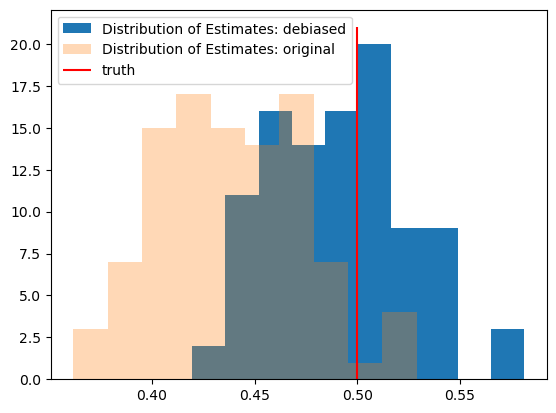

In [16]:
import matplotlib.pyplot as plt
plt.hist(points_base, label='Distribution of Estimates: debiased')
plt.hist(points_alt, label='Distribution of Estimates: original', alpha=.3)
plt.vlines([c], 0, plt.ylim()[1], color='red', label='truth')
plt.legend()
plt.show()